In [1]:
import matplotlib.pyplot as plt

import numpy as np
from tqdm.notebook import tqdm

from mcopt.pipeline import Pipeline
from mcopt import MorseGraph, ot

In [2]:
pipeline = Pipeline('../pipeline.config.json')

red_sea = pipeline.complex('red_sea')

> Loading red_sea complex
  config unchanged, reading complex


In [3]:
cmap = 'cool'

random_state = 42
rng = np.random.default_rng(random_state)

sample_rate = 5

num_random_iter = 10

ms = [0.9 + 0.02 * i for i in range(0, 6)]
ms

[0.9, 0.92, 0.9400000000000001, 0.96, 0.98, 1.0]

In [4]:
graphs = [frame.to_graph().sample(sample_rate) for frame in red_sea.frames]

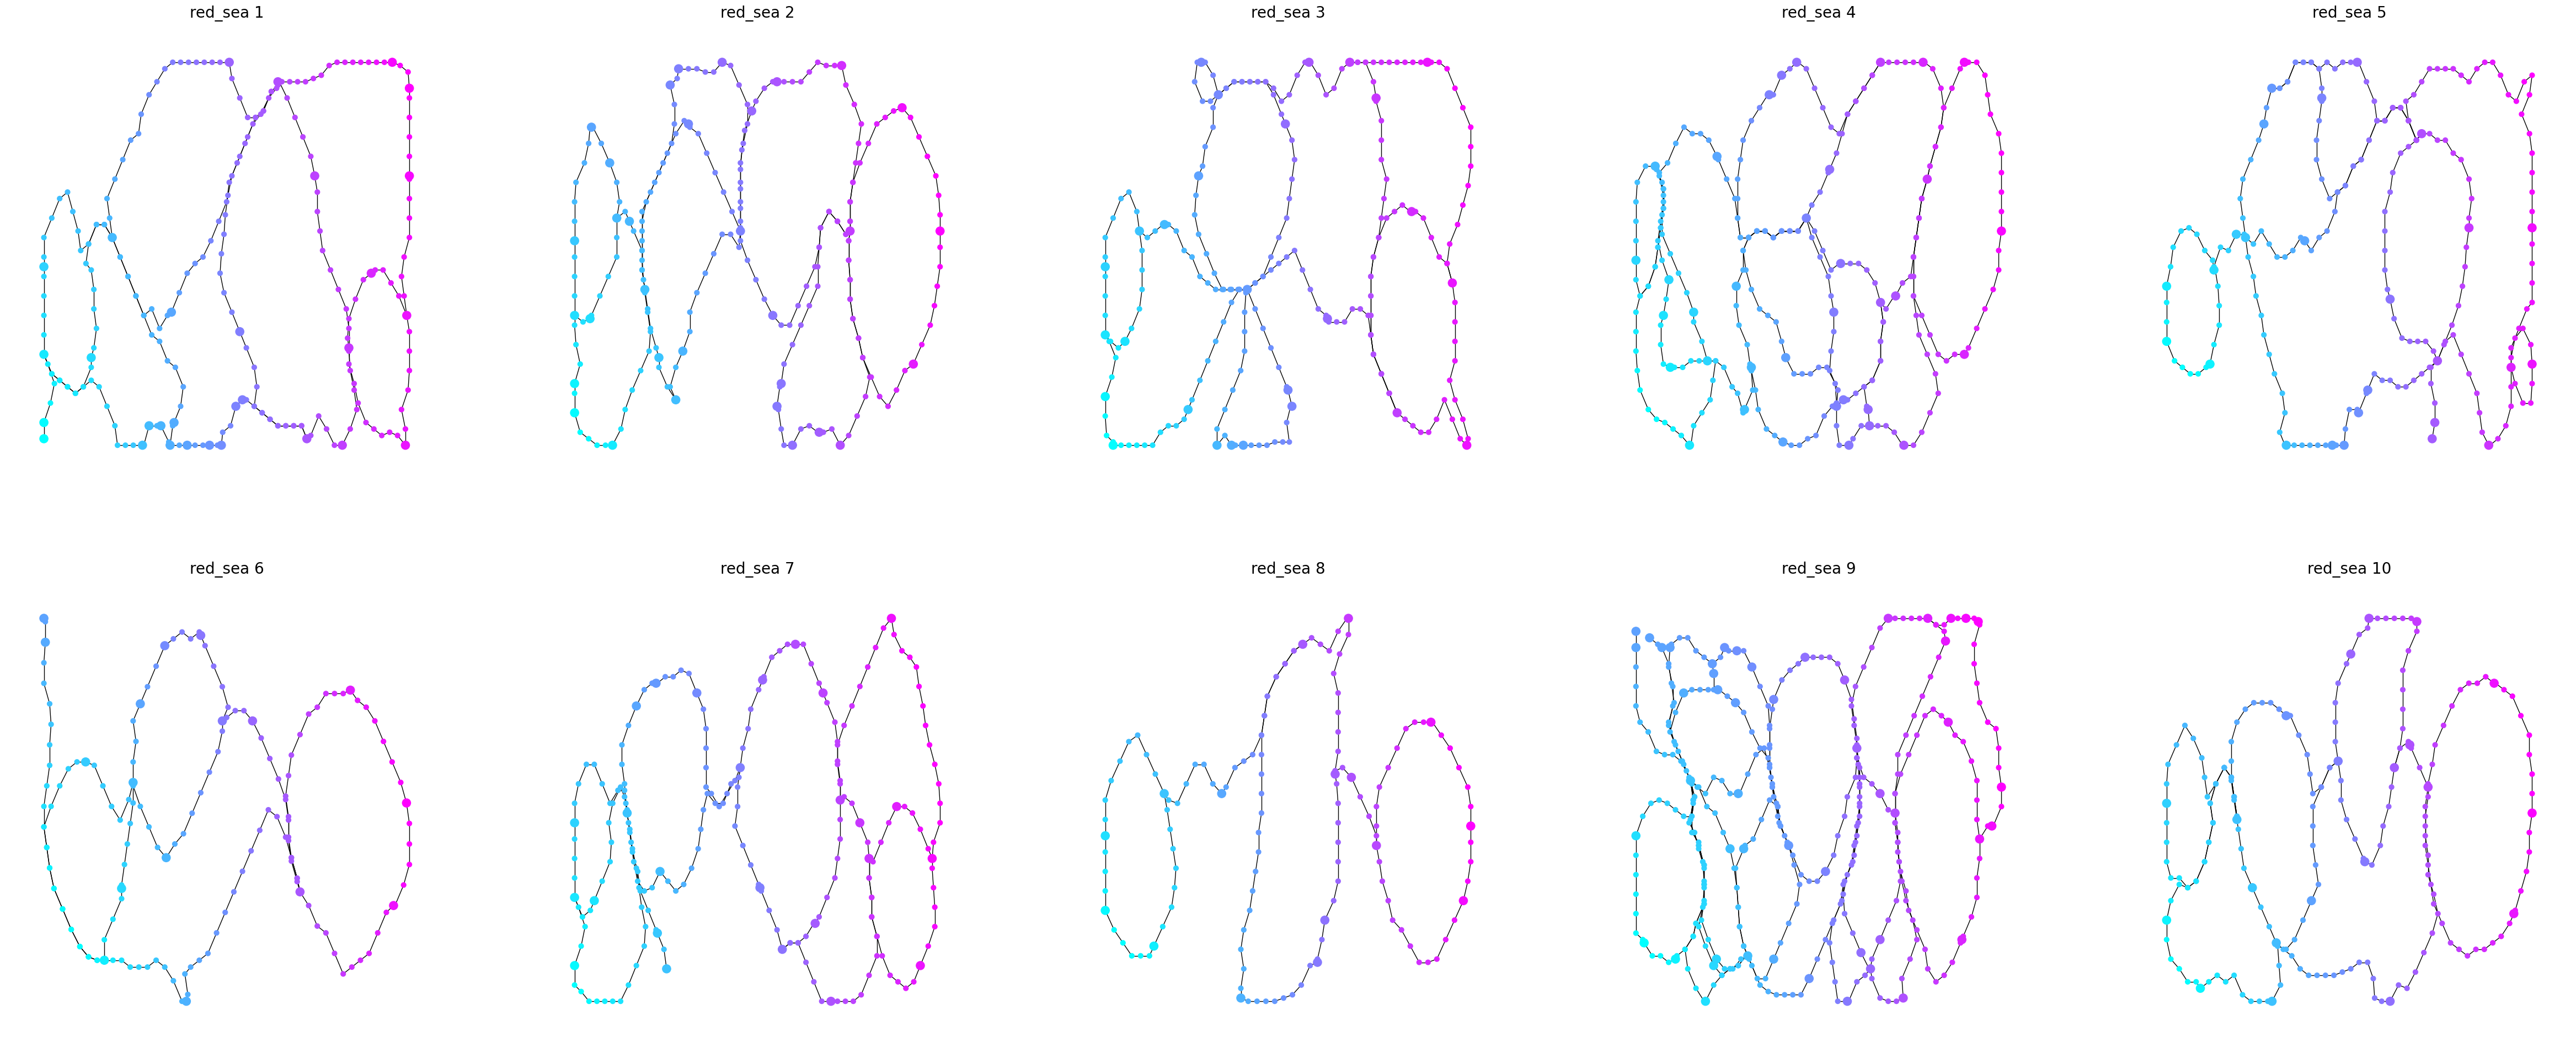

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(60, 24))

for i, (graph, ax) in enumerate(zip(graphs, axes.ravel())):
  graph.draw(ax=ax, cmap=cmap)
  ax.set_title(f'red_sea {i + 1}', fontsize=20)

In [6]:
results = np.zeros(shape = (len(ms), len(graphs) - 1))

In [15]:
src = graphs[0]
src_net = src.to_mpn(hist='degree', dist='geo')

for dest_i, dest in enumerate(tqdm(graphs[1:], desc='graphs', leave=False)):
  M = MorseGraph.attribute_cost_matrix(src, dest)
  
  dest_net = dest.to_mpn(hist='degree', dist='geo')
    
  for m_i, m in enumerate(tqdm(ms, desc='m(s)', leave=False)):
    min_dist = float('inf')
    min_coupling = None
    
    for _ in tqdm(range(num_random_iter), desc='tune init', leave=False):
      if np.isclose(m, 1):
        coupling, dist = ot.fGW(src_net, dest_net, M, random_G0 = True, random_state=rng)
      else:
        coupling, dist = ot.fpGW(src_net, dest_net, m, M, random_G0 = True, random_state=rng)
      
      if dist < min_dist:
        min_dist = dist
        min_coupling = coupling
        
    max_match_dist = float('-inf')    
    
    for dest_n in dest.nodes:
      i = min_coupling.dest_rev_map[dest_n]
      src_i = coupling[:, i].argmax()
      
      if np.isclose(coupling[src_i, i], 0):
        continue
      
      src_n = coupling.src_map[src_i]
      dest_pos = dest.nodes(data='pos2')[dest_n]
      src_pos = src.nodes(data='pos2')[src_n]
      
      match_dist = np.linalg.norm(src_pos - dest_pos)
      
      if match_dist > max_match_dist:
        max_match_dist = match_dist
      
    results[m_i, dest_i] = max_match_dist

graphs:   0%|          | 0/9 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

m(s):   0%|          | 0/6 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
results.max(axis=0)

array([68.9492567 , 43.17696145, 67.507407  , 52.15361924, 55.        ,
       40.04060439, 55.50900828, 56.46237685, 47.36296021])

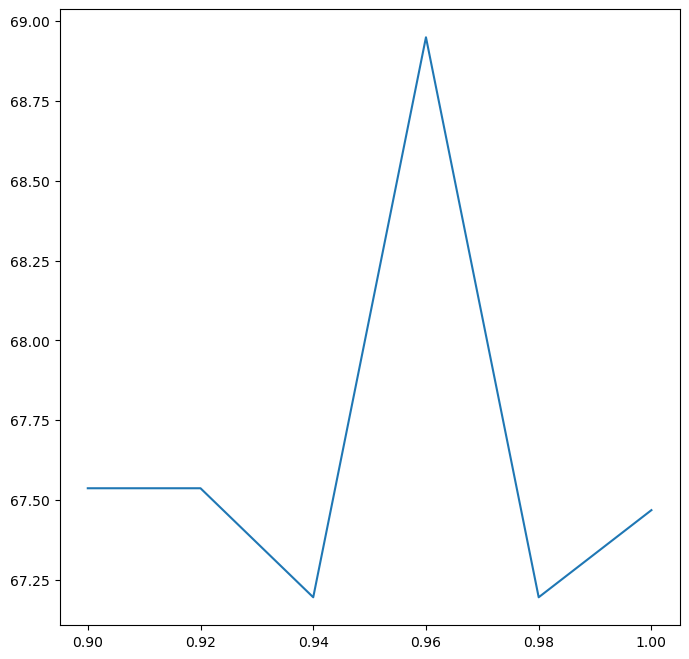

In [20]:
x = ms
y = results.max(axis=1)

plt.plot(x, y)

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

tune init:   0%|          | 0/10 [00:00<?, ?it/s]

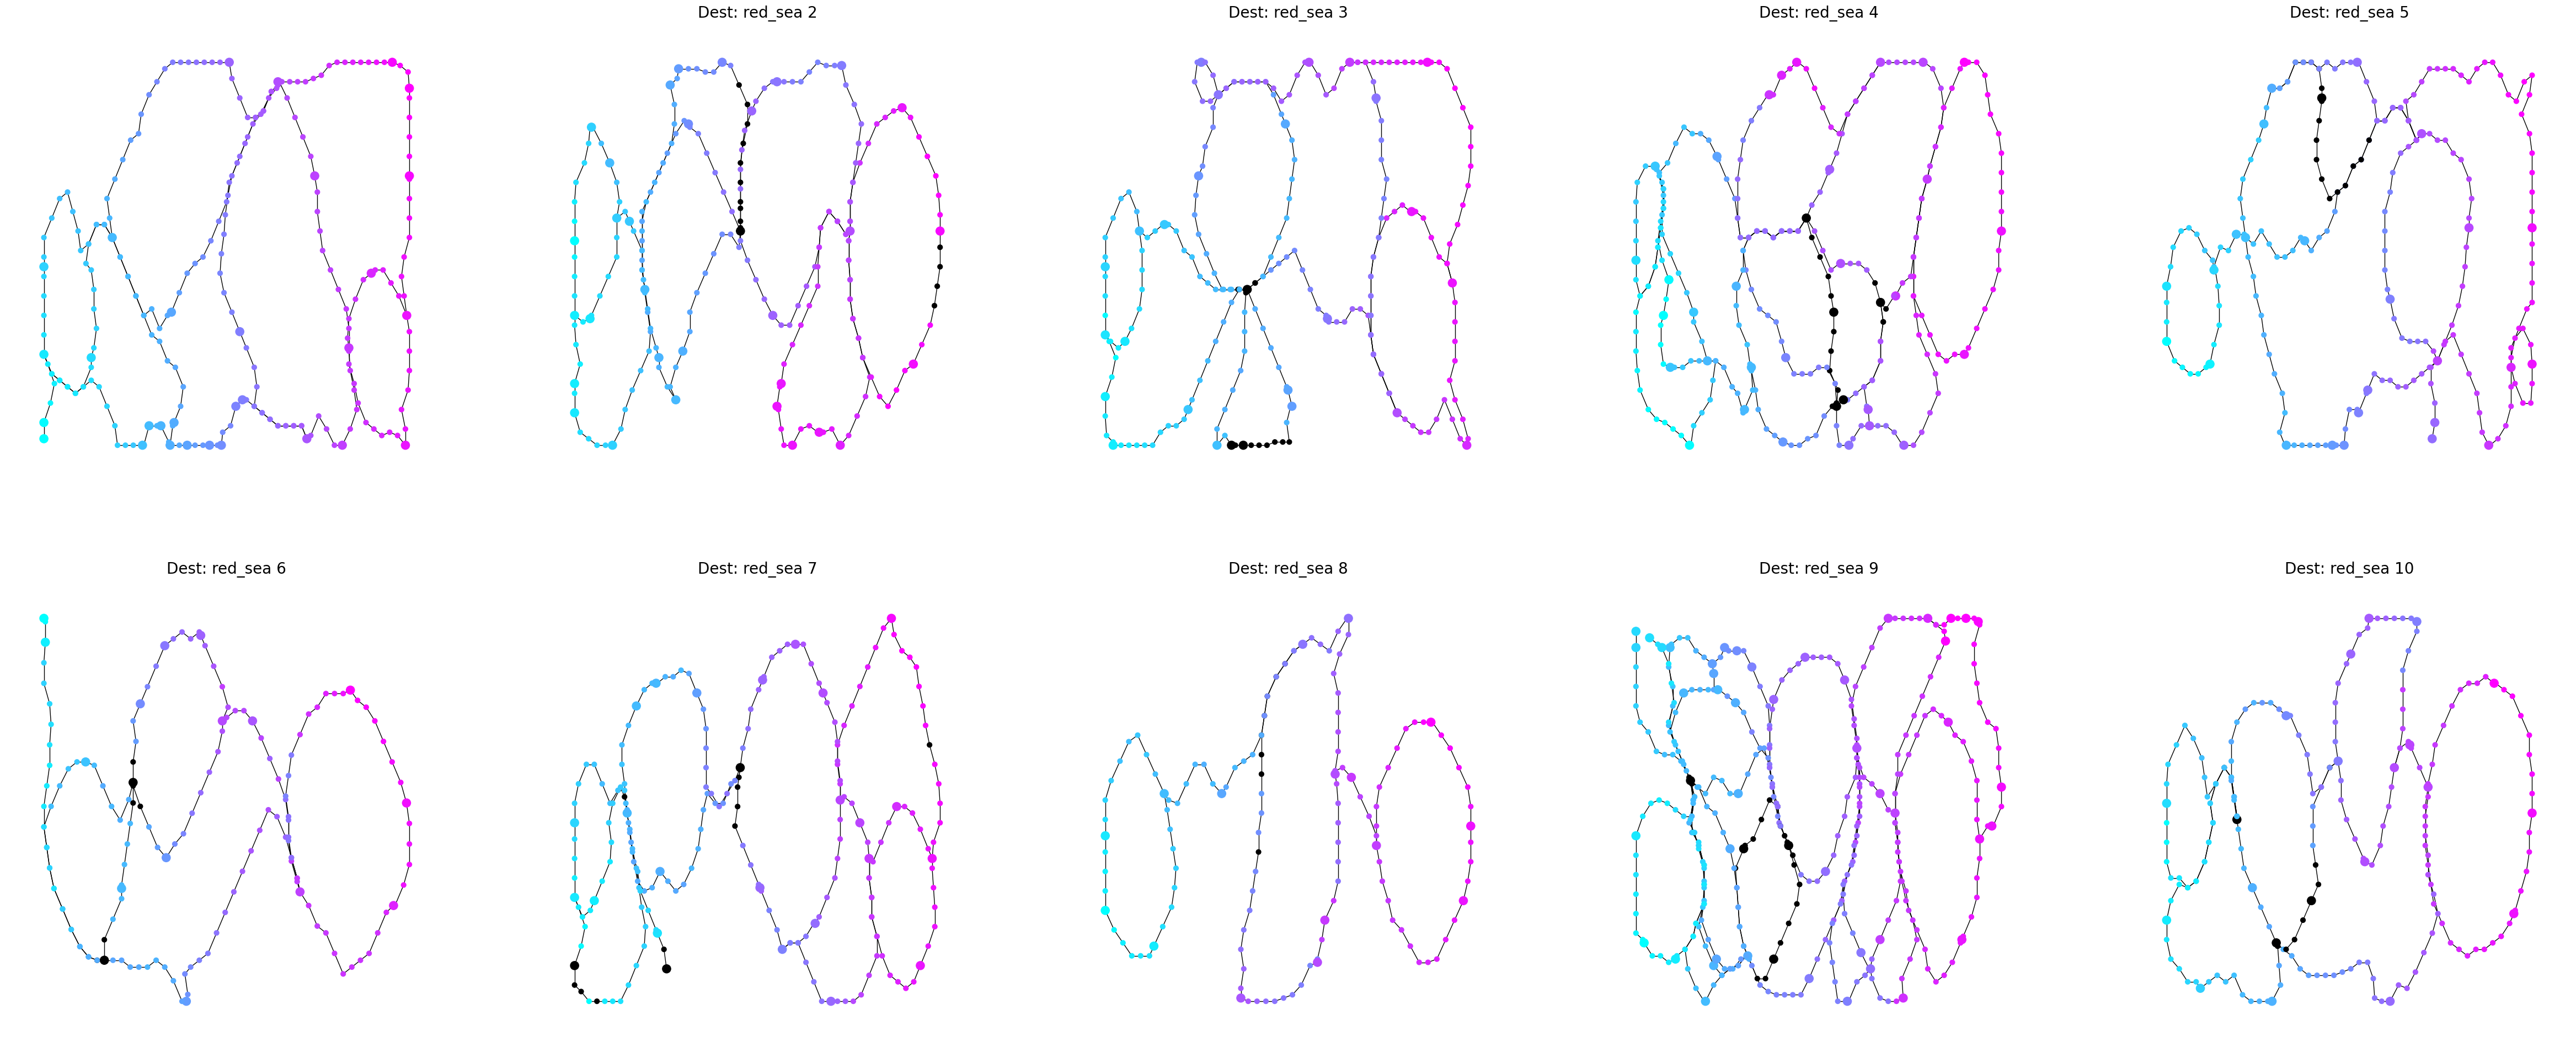

In [24]:
m = 0.92
fig, axes = plt.subplots(2, 5, figsize=(60, 24))

src_node_color = src.node_color_by_position()
src.draw(
  ax=axes[0,0],
  cmap=cmap,
  node_color=src_node_color
)
ax.set_title('Source: red_sea 1')

for i, (dest, ax) in enumerate(zip(graphs[1:], axes.ravel()[1:])):
  M = MorseGraph.attribute_cost_matrix(src, dest)
  
  dest_net = dest.to_mpn(hist='degree', dist='geo')
  
  min_dist = float('inf')
  min_coupling = None
  
  for _ in range(num_random_iter):
    if np.isclose(m, 1):
      coupling, dist = ot.fGW(src_net, dest_net, M, random_G0 = True, random_state=rng)
    else:
      coupling, dist = ot.fpGW(src_net, dest_net, m, M, random_G0 = True, random_state=rng)
    
    if dist < min_dist:
      min_dist = dist
      min_coupling = coupling
  
  dest.draw(
    ax=ax, 
    cmap=cmap,
    node_color=dest.node_color_by_coupling(src_node_color, min_coupling)
  )
  ax.set_title(f'Dest: red_sea {i + 2}', fontsize=20)

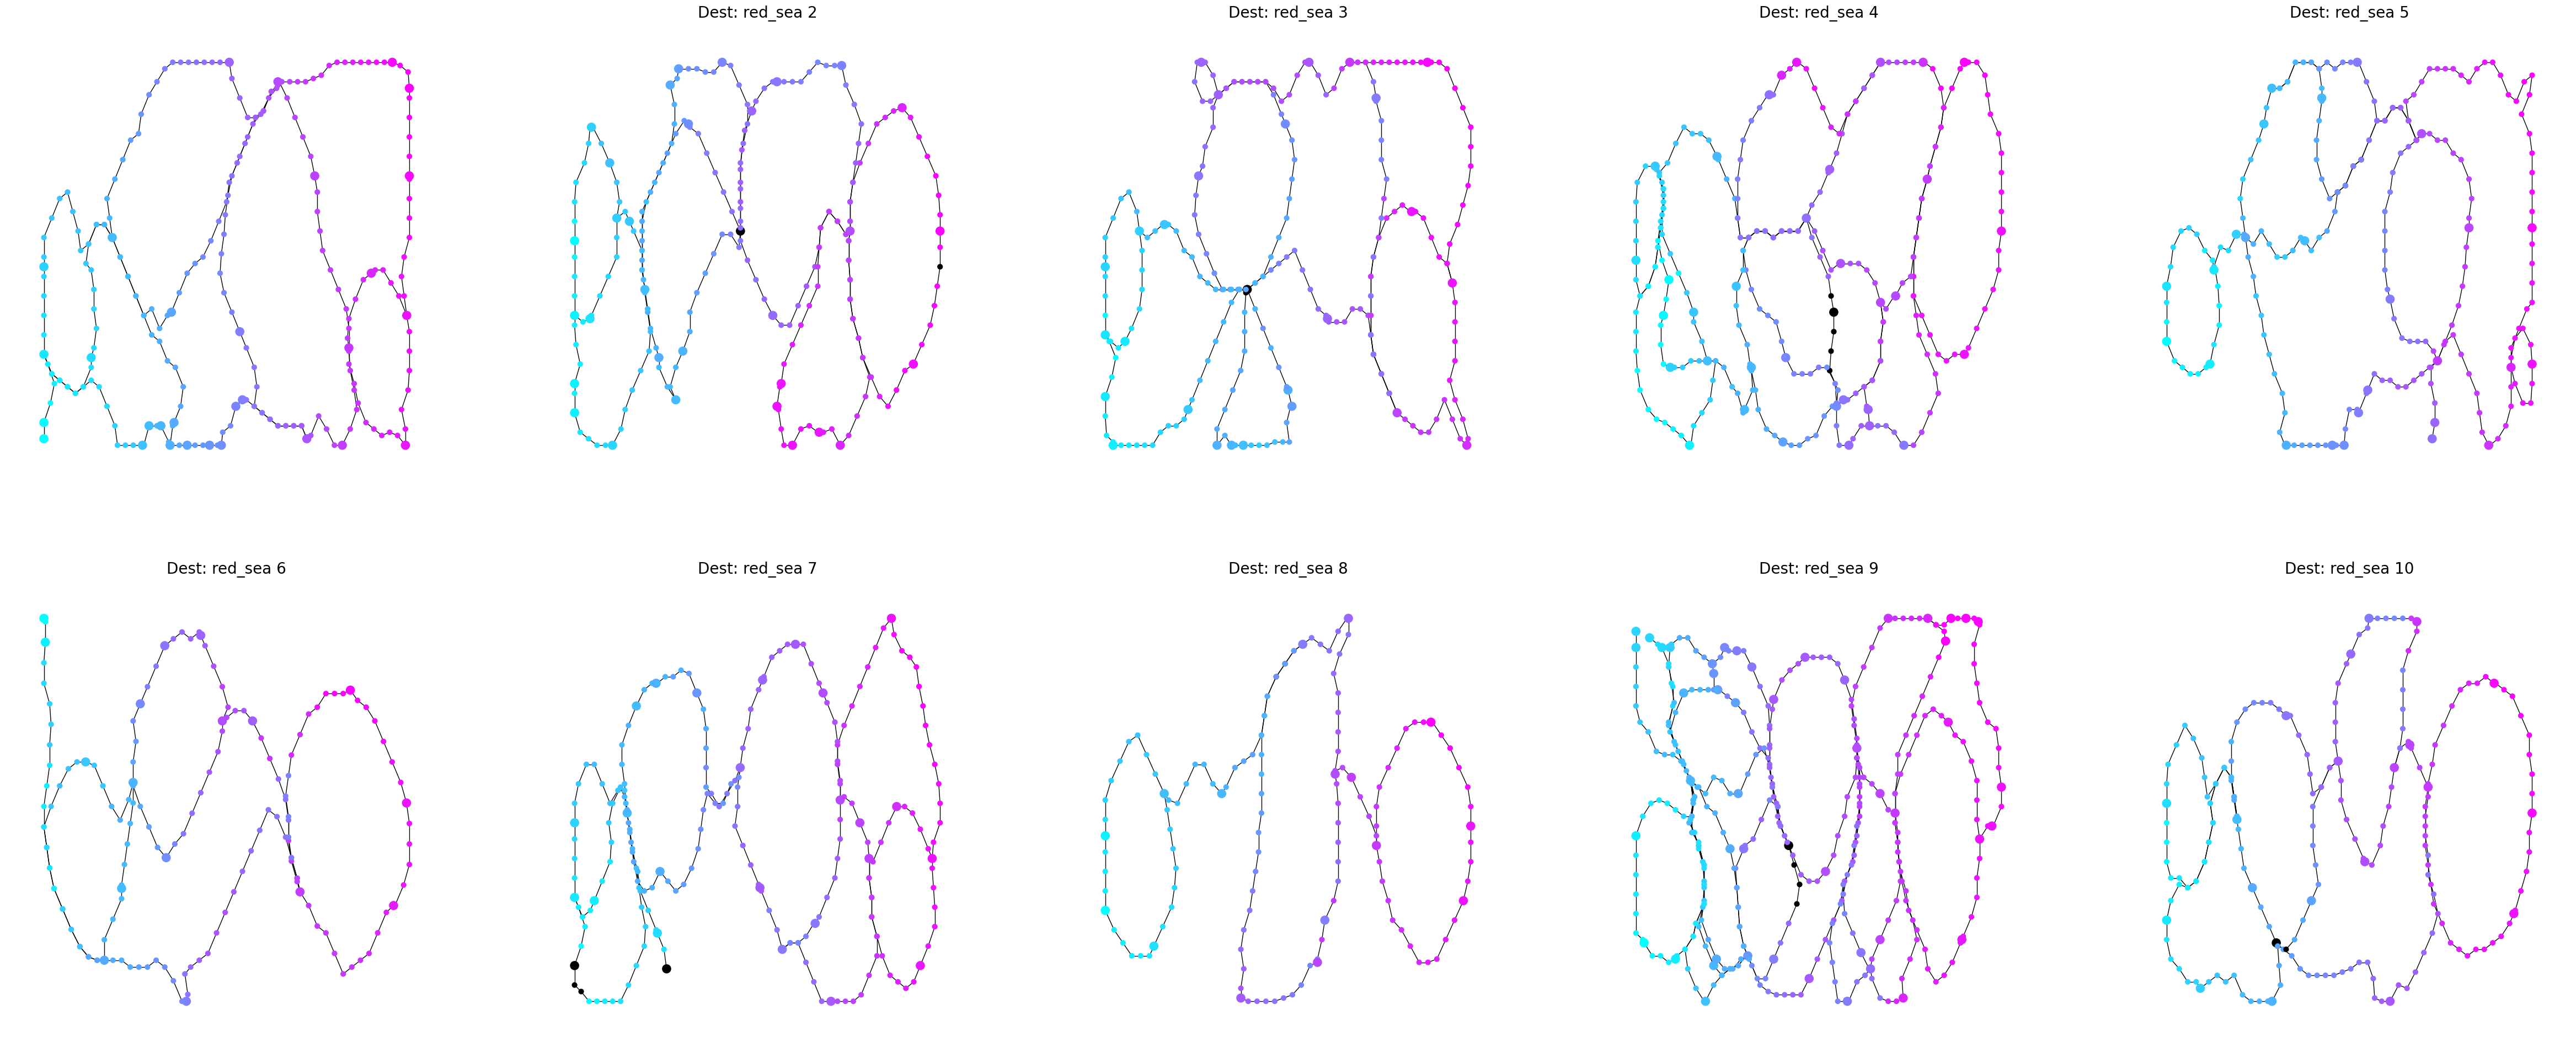

In [26]:
m = 0.98
fig, axes = plt.subplots(2, 5, figsize=(60, 24))

src_node_color = src.node_color_by_position()
src.draw(
  ax=axes[0,0],
  cmap=cmap,
  node_color=src_node_color
)
ax.set_title('Source: red_sea 1')

for i, (dest, ax) in enumerate(zip(graphs[1:], axes.ravel()[1:])):
  M = MorseGraph.attribute_cost_matrix(src, dest)
  
  dest_net = dest.to_mpn(hist='degree', dist='geo')
  
  min_dist = float('inf')
  min_coupling = None
  
  for _ in range(num_random_iter):
    if np.isclose(m, 1):
      coupling, dist = ot.fGW(src_net, dest_net, M, random_G0 = True, random_state=rng)
    else:
      coupling, dist = ot.fpGW(src_net, dest_net, m, M, random_G0 = True, random_state=rng)
    
    if dist < min_dist:
      min_dist = dist
      min_coupling = coupling
  
  dest.draw(
    ax=ax, 
    cmap=cmap,
    node_color=dest.node_color_by_coupling(src_node_color, min_coupling)
  )
  ax.set_title(f'Dest: red_sea {i + 2}', fontsize=20)